# Example 03. Process a LEAF time-series

This example generates analyzes a Plant Area Volume Density (PAVD) profile time-series acquired by a LEAF instrument.

## Load all the required modules

In [1]:
import os
import glob
import time
import datetime
import numpy as np
from scipy.optimize import curve_fit,minimize

from pylidar_tls_canopy import leaf_io, plant_profile, grid, visualize
from pylidar_tls_canopy.rsmooth import rsmooth

## Settings

In [3]:
sensor_id = 362 # LEAF instrument ID
sensor_height = 1.5 # Height above ground of the sensor head (m)
max_h = 40 # Maximum height for visualization (m)
max_pai = None # Maximum PAI for visualization
hres = 0.5 # Vertical resolution of profiles (m)
zenith_offset = 0 # Fixed zenith offset for LEAF scans (rad)

## Identify all of the input files

Create a list of all files available to generate a time-series.

In [4]:
# SERC
os.chdir(f'/gpfs/data1/vclgp/data/leaf/serc/23May23/{sensor_id:d}')
hemi_hi_csv_list = glob.glob('data/ESS?????_*_hemi_*_0800_0400.csv')
hemi_low_csv_list = glob.glob('data/ESS?????_*_hemi_*_0200_0100.csv')
hinge_csv_list = glob.glob('data/ESS?????_*_hinge_*.csv')
ground_csv_list = glob.glob('data/ESS?????_*_ground_*.csv')
power_csv_lisst = glob.glob('pwr/ESS?????_pwr_*.csv')


In [5]:
# Example hinge/hemi pair
hemi_file = 'data/ESS00362_1057_hemi_20230520-080028Z_0800_0400.csv'
hinge_file = 'data/ESS00362_1055_hinge_20230520-060028Z_0005_5410.csv'

In [6]:
f = leaf_io.LeafScanFile(hemi_file, sensor_height=sensor_height)
f.data.head()

,sample_count,scan_encoder,rotary_encoder,range1,intensity1,range2,sample_time,target_count,datetime,zenith,azimuth,x1,y1,z1,h1,x2,y2,z2,h2
0,108,1362.5,0,1.75,100,1.75,28.75,2,2023-05-20 08:00:28.028750,2.238971,3.427504,-0.387419,-1.317905,-1.084220,0.415780,-0.387419,-1.317905,-1.084220,0.415780
1,109,1375.0,0,1.91,100,2.00,26.98,2,2023-05-20 08:00:28.055730,2.231117,3.427504,-0.425448,-1.447272,-1.171537,0.328463,-0.445495,-1.515468,-1.226740,0.273260
2,110,1387.5,0,2.14,100,2.14,28.35,2,2023-05-20 08:00:28.084080,2.223263,3.427504,-0.479573,-1.631391,-1.299297,0.200703,-0.479573,-1.631391,-1.299297,0.200703
3,111,1400.0,0,2.17,100,2.34,27.38,2,2023-05-20 08:00:28.111460,2.215409,3.427504,-0.489199,-1.664137,-1.303929,0.196071,-0.527523,-1.794508,-1.406080,0.093920
4,112,1412.5,0,2.40,100,2.40,27.71,2,2023-05-20 08:00:28.139170,2.207555,3.427504,-0.544227,-1.851330,-1.427022,0.072978,-0.544227,-1.851330,-1.427022,0.072978


## Visualize the 3D point cloud

Let's check the hinge angle scan is where we think it is

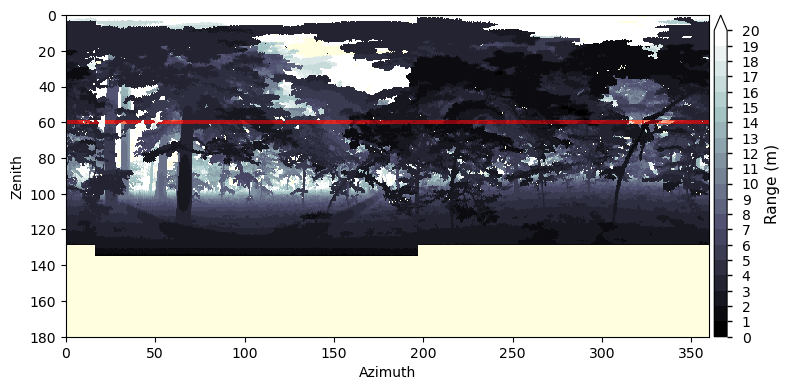

In [7]:
# Resolution should be 0.45 (high), 0.9 (medium) or 1.8 (low) for hemi scans
leaf_hemi_grid = grid.grid_leaf_spherical(hemi_file, 0.45, attribute='range1',
    method='MIN', sensor_height=sensor_height, zenith_offset=zenith_offset)

leaf_hinge_grid = grid.grid_leaf_spherical(hinge_file, 0.45, attribute='range1',
    method='MIN', sensor_height=sensor_height, zenith_offset=zenith_offset)

visualize.plot_leaf_grid(leaf_hemi_grid, label='Range (m)', clim=[0,20], figsize=(8,6), 
               nbins=20, cmap='bone', extent=[0,360,180,0], inset=leaf_hinge_grid,
               xlabel='Azimuth', ylabel='Zenith', facecolor='lightyellow', inset_cmap='Reds_r')

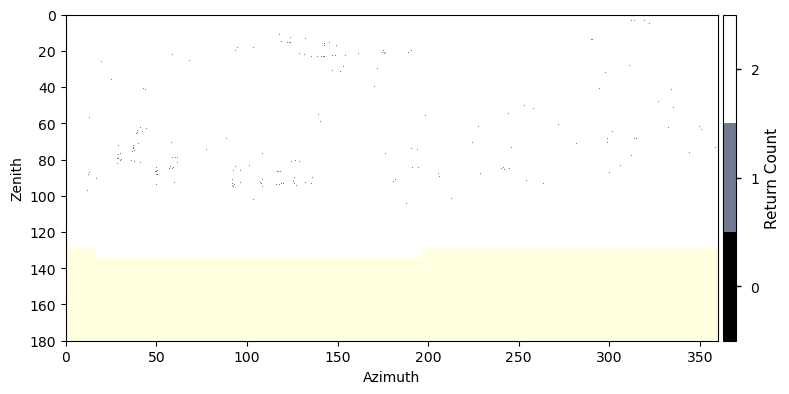

In [8]:
leaf_spherical_grid = grid.grid_leaf_spherical(hemi_file, 0.45, attribute='target_count',
    method='MIN', sensor_height=sensor_height, zenith_offset=zenith_offset)

visualize.plot_leaf_grid(leaf_spherical_grid, label='Return Count', clim=[-0.5,2.5], figsize=(8,6), 
               nbins=3, cmap='bone', extent=[0,360,180,0], xlabel='Azimuth', 
               ylabel='Zenith', facecolor='lightyellow', extend='neither')

## Generate $P_{gap}$ profiles for a single hemi scan

Plot the $P_{gap}$ profiles for an example scan. There are different methods used for $P_{gap}$ estimation: WEIGHTED (weighting of returns by 1 / target_count), FIRST (first returns only), ALL (all returns), FIRSTLAST (each return has a weight of 0.5).

I'm currently using the FIRSTLAST method for LEAF data, since first and last returns from the same target will often be from extended targets and the interception will have a weight of 1 (each return from the same pulse will typically fall within the same height bin), and returns distributed along the beam path will have a lower weighting that is more appropriate for partial interceptions.

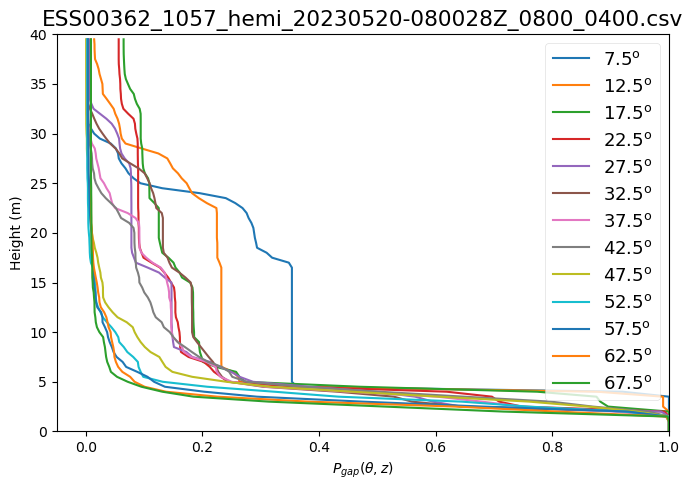

In [9]:
vpp = plant_profile.Jupp2009(hres=hres, zres=5, ares=90, min_z=5, max_z=70, min_h=0, max_h=max_h)
valid = vpp.add_leaf_scan_position(hemi_file, method='FIRSTLAST', zenith_offset=zenith_offset, 
                                   min_zenith=5, max_zenith=70, sensor_height=sensor_height)
if valid:
    vpp.get_pgap_theta_z()
    title = os.path.basename(hemi_file)
    pgap_labels = [fr'{b:.1f}$\rm ^o$' for b in vpp.zenith_bin]
    visualize.plot_vertical_profiles(vpp.pgap_theta_z, vpp.height_bin, xlabel=r'$P_{gap}(\theta,z)$',
                           labels=pgap_labels, ylim=[0,max_h], xlim=[None,1], figsize=[7,5], title=title)

## Compare the hinge and hemi scans for the same date

The hinge scans are designed for PAI profiles and the hemi scans for visualization of terrain and understorey structure. 
But can they produce the same vertical profiles?

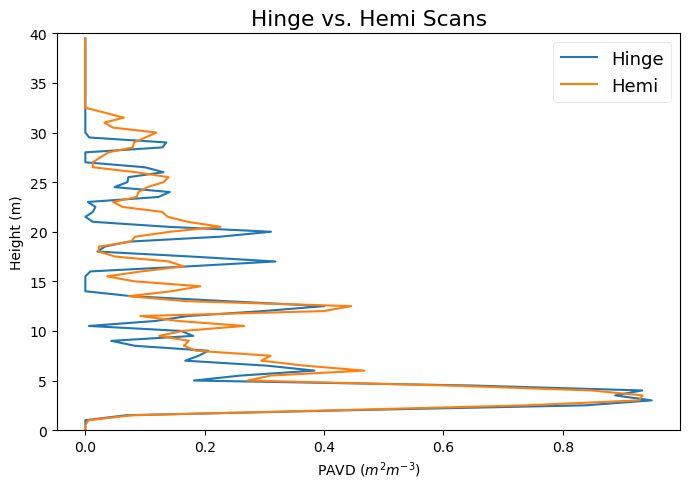

In [10]:
hemi_vpp = plant_profile.Jupp2009(hres=hres, zres=5, ares=90, min_z=55, max_z=60, min_h=0, max_h=max_h)
hemi_valid = hemi_vpp.add_leaf_scan_position(hemi_file, method='FIRSTLAST', zenith_offset=zenith_offset, 
                                   min_zenith=55, max_zenith=60, sensor_height=sensor_height)
hemi_vpp.get_pgap_theta_z(min_azimuth=0, max_azimuth=360)
hemi_pai = hemi_vpp.calcHingePlantProfiles()
hemi_pavd = hemi_vpp.get_pavd(hemi_pai)

hinge_vpp = plant_profile.Jupp2009(hres=hres, zres=5, ares=90, min_z=55, max_z=60, min_h=0, max_h=max_h)
hinge_valid = hinge_vpp.add_leaf_scan_position(hinge_file, method='FIRSTLAST', zenith_offset=zenith_offset, 
                                   min_zenith=55, max_zenith=60, sensor_height=sensor_height)
hinge_vpp.get_pgap_theta_z(min_azimuth=0, max_azimuth=360)
hinge_pai = hinge_vpp.calcHingePlantProfiles()
hinge_pavd = hinge_vpp.get_pavd(hinge_pai)

visualize.plot_vertical_profiles([hinge_pavd,hemi_pavd], vpp.height_bin, 
   labels=['Hinge','Hemi'], ylim=[0,max_h], figsize=[7,5], title='Hinge vs. Hemi Scans')

## Compare profiles calculated using hinge and hemi methods 

Only using the hinge angle minimizes the impact of variation in leaf angle projection on estimates of PAI and PAVD, however hemispherical measurements permit the use of other methods to account for this variation. Hemispherical scans also provide more representative sampling of the canopy. Do hinge and hemispherical methods produce the same vertical profiles?

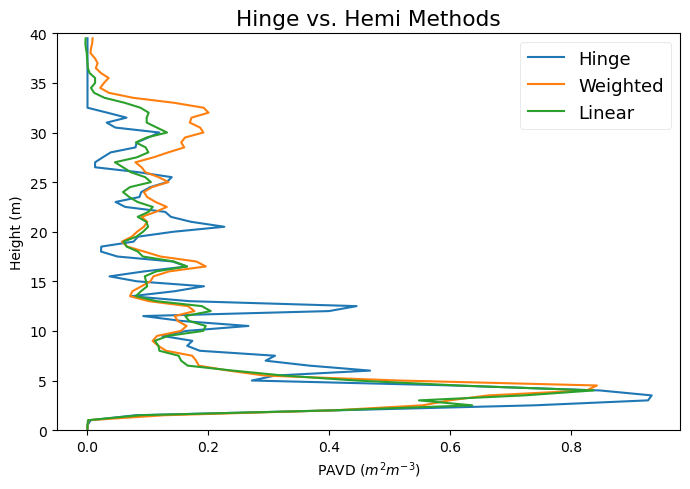

In [11]:
hemi_vpp = plant_profile.Jupp2009(hres=hres, zres=5, ares=90, min_z=5, max_z=70, min_h=0, max_h=max_h)
hemi_valid = hemi_vpp.add_leaf_scan_position(hemi_file, method='FIRSTLAST', zenith_offset=zenith_offset, 
                                   min_zenith=5, max_zenith=70, sensor_height=sensor_height)
hemi_vpp.get_pgap_theta_z(min_azimuth=0, max_azimuth=360)

hinge_pai = hemi_vpp.calcHingePlantProfiles()
hinge_pavd = hemi_vpp.get_pavd(hinge_pai)

weighted_pai = hemi_vpp.calcSolidAnglePlantProfiles()
weighted_pavd = hemi_vpp.get_pavd(weighted_pai)

linear_pai = hemi_vpp.calcLinearPlantProfiles()
linear_pavd = hemi_vpp.get_pavd(linear_pai)

visualize.plot_vertical_profiles([hinge_pavd,weighted_pavd,linear_pavd], vpp.height_bin, 
   labels=['Hinge','Weighted','Linear'], ylim=[0,max_h], figsize=[7,5], title='Hinge vs. Hemi Methods')

## Analyze the PAI time-series

Analysis of the daily time-series is needed for filtering of observations affected by wind, rain or other pertubations. Here we use robust smoothing of regular time-series data to identify outliers, but these should be checked against auxillary data. Temperature, humidity, and power data recorded by the LEAF instrument did not appear to be related to these outliers, at least for this example. Given this example is a deciduous forest, we also fit a sigmoid function to time-series to quantify the change in PAI during senescence and leaf drop.

### Read the data

In [12]:
nbins = int(max_h / hres)

# LEAF filenaming convention permits sorting by date
leaf_hinge_files = sorted(hinge_csv_list)
nobs = len(leaf_hinge_files)

In [13]:
leaf_hinge_vpp = []

for leaf_file in leaf_hinge_files:
    vpp = plant_profile.Jupp2009(hres=hres, zres=5, ares=90, min_h=0, max_h=max_h)
    try:
        valid = vpp.add_leaf_scan_position(leaf_file, method='FIRSTLAST', 
                                           min_zenith=55, max_zenith=60, 
                                           sensor_height=sensor_height,
                                           zenith_offset=zenith_offset)

        if valid:
            vpp.get_pgap_theta_z(min_azimuth=0, max_azimuth=360)
        else:
            msg = f'Empty scan: {leaf_file}'
            print(msg)

        leaf_hinge_vpp.append(vpp)
    except Exception:
        msg = f'Problem scan: {leaf_file}'
        print(msg)

### Create a regular time-series

In [14]:
ndays = (leaf_hinge_vpp[-1].datetime - leaf_hinge_vpp[0].datetime).days + 1
leaf_dates = np.array([leaf_hinge_vpp[0].datetime + datetime.timedelta(days=d) for d in range(ndays)])
nobs = len(leaf_hinge_vpp)

scan_hours, scan_count = np.unique([p.datetime.hour for p in leaf_hinge_vpp], return_counts=True)
scan_hours = [h for h,c in zip(scan_hours,scan_count) if c > 1]

pai_z_grids = []
quality_flag = []
for scan_hour in scan_hours:
    
    with grid.LidarGrid(ndays, nbins, 0, nbins, resolution=1, init_cntgrid=True) as grd:
        for i in range(nobs):
            d = leaf_hinge_vpp[i].datetime
            day = (d - leaf_hinge_vpp[0].datetime).days
            if d.hour == scan_hour:
                if hasattr(leaf_hinge_vpp[i], 'pgap_theta_z'):
                    pai = leaf_hinge_vpp[i].calcHingePlantProfiles()
                    grd.add_column(pai, day, method='MEAN')
        
        grd.finalize_grid(method='MEAN')
        pai_z_grid = grd.get_grid()
    
    pai_z_grids.append(pai_z_grid)

### Quality filtering

The smoothing and filtering is done using:
Garcia, Damien. 2010. "Robust Smoothing of Gridded Data in One and Higher Dimensions with Missing Values."
Computational Statistics & Data Analysis 54 (4): 1167–78. https://doi.org/10.1016/j.csda.2009.09.020.

The optimal smoothing parameter (p) is, by default, determined by generalized cross-validation. You can choose to set this to a constant using rsmooth.

Different parameters and classification criteria may be required for filtering depending on time-series length, complexity and noise. We will add some guidelines for determining these in the near future.

In [15]:
bp = [0,50,150,pai_z_grids[0].shape[2]] # breakpoints used to define segments
p = [1, None, 1] # smoothing parameter (None means determine through cross validation for that segment)
max_k = [6,6,6] # number of iterations used for calculation of robust weights per segment

pai = []
pai_smooth = []
quality_flags = []
for pai_z_grid in pai_z_grids:
    
    pai_z0 = np.zeros(pai_z_grid.shape[2])
    pai_smooth_tmp = np.zeros(pai_z_grid.shape[2])
    bad_data = np.zeros(pai_z_grid.shape[2], dtype=bool)
    for i in range(len(bp)-1):
        
        pai_z0_segment = np.where(pai_z_grid[0,-1,bp[i]:bp[i+1]] > 0, pai_z_grid[0,-1,bp[i]:bp[i+1]], np.nan)

        smooth_tmp,weights = rsmooth(pai_z0_segment, p=p[i], max_k=max_k[i])
        resid = pai_z0_segment - smooth_tmp

        # the calculation of bad_data_segment may need to be customized
        # using different thresholding of weights and resid
        bad_data_segment = np.isnan(pai_z0_segment)
        bad_data_segment |= (weights <= 0) 
        bad_data_segment |= (resid < -1)
        
        pai_z0[bp[i]:bp[i+1]] = pai_z0_segment
        pai_smooth_tmp[bp[i]:bp[i+1]] = smooth_tmp
        bad_data[bp[i]:bp[i+1]] = bad_data_segment
        
    quality_flags.append(~bad_data)
    pai_smooth.append(pai_smooth_tmp)
    pai.append(pai_z0)

### Phenology

In [16]:
# Define a sigmoid function
def sigmoid(x, L , x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0))) + b
    return y

# Define a double sigmoid function
def double_sigmoid(p, x):
    sigma1 = 1.0 / (1 + np.exp(p[2] * (x - p[3])))
    sigma2 = 1.0 / (1 + np.exp(-p[4] * (x - p[5])))
    return p[0] - p[1] * (sigma1 + sigma2 - 1)

# Define the cost function for the double sigmoid
def cost_function(p, t, y_obs, passer, sigma_obs, func=double_sigmoid):
    y_pred = func(p, t)
    cost = -0.5 * (y_pred[passer] - y_obs)**2 / sigma_obs**2
    return -cost.sum()

In [17]:
# Fit the sigmoid model
pai_sigmoid = []
for pai_z0,quality_flag in zip(pai,quality_flags):
    real_dates = np.array([(d - leaf_dates[0]).days for d in leaf_dates], dtype=float)
    try:      
        p0 = np.array([2, 5, 0.1, 20, 0.1, 200])
        n = np.count_nonzero(quality_flag)
        result = minimize(cost_function, p0, args=(real_dates, pai_z0[quality_flag], quality_flag, np.ones(n)))
        yfit = double_sigmoid(result.x, real_dates)
        
        pai_sigmoid.append(yfit)
    except (ValueError,RuntimeError) as e:
        pai_sigmoid.append(None)
        print(e)

### Plot the results

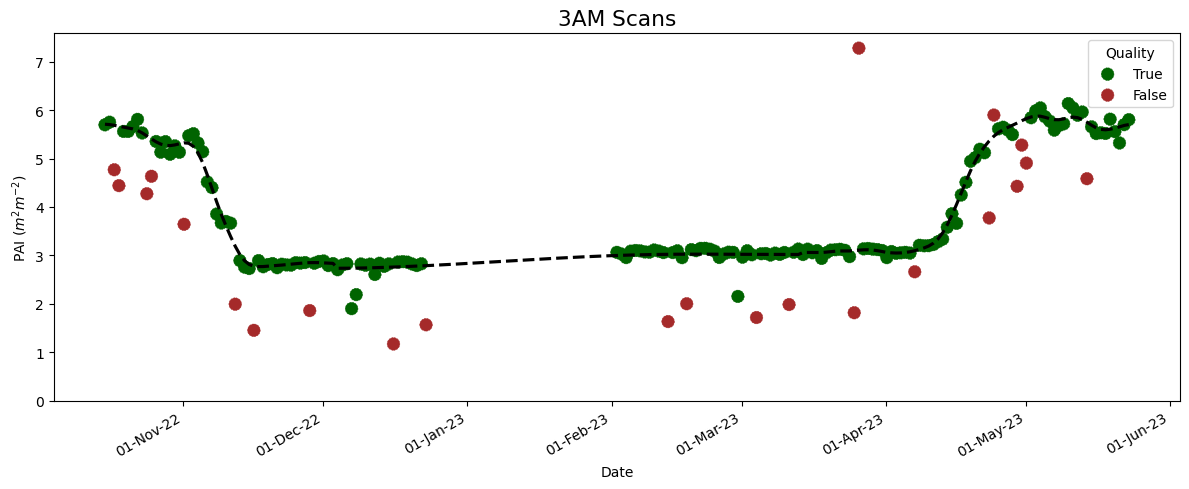

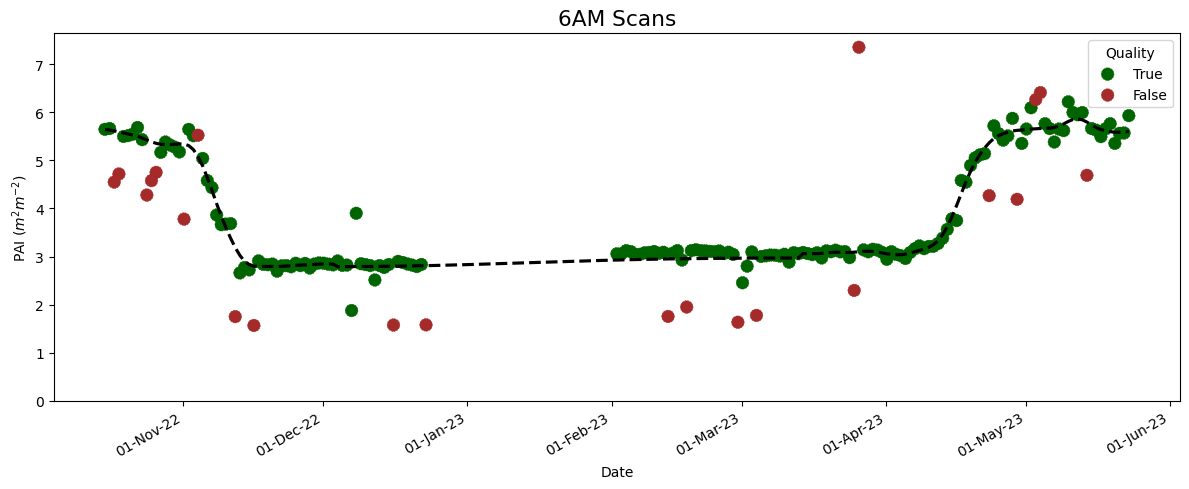

In [18]:
for i,scan_hour in enumerate(scan_hours):
    title = f'{scan_hour:d}AM Scans'
    visualize.plot_timseries_1d(leaf_dates, pai[i], quality_flags[i], fitted=pai_smooth[i],
                      xlim=[None,None], ylim=[0,max_pai], title=title, linestyle='dashed',
                      ylabel=r'PAI ($m^{2} m^{-2}$)', figsize=(12,5))

## Grid the daily PAVD time-series

Aggregate all the data on a regular daily grid. Note that two out of three LEAF instruments at this site (362 and 363) were switched, so the source data needs to be corrected.

In [19]:
with grid.LidarGrid(ndays, nbins, 0, nbins, resolution=1, init_cntgrid=True) as grd:
    for i in range(nobs):
        d = leaf_hinge_vpp[i].datetime
        day = (d - leaf_hinge_vpp[0].datetime).days
        if d.hour in scan_hours:
            scan = scan_hours.index(d.hour)
            if quality_flags[scan][day]:
                if hasattr(leaf_hinge_vpp[i], 'pgap_theta_z'):
                    pai_z = leaf_hinge_vpp[i].calcHingePlantProfiles()
                    pavd = leaf_hinge_vpp[i].get_pavd(pai_z)
                    grd.add_column(pavd, day, method='MEAN')
        
    grd.finalize_grid(method='MEAN')
    pavd_grid = grd.get_grid()

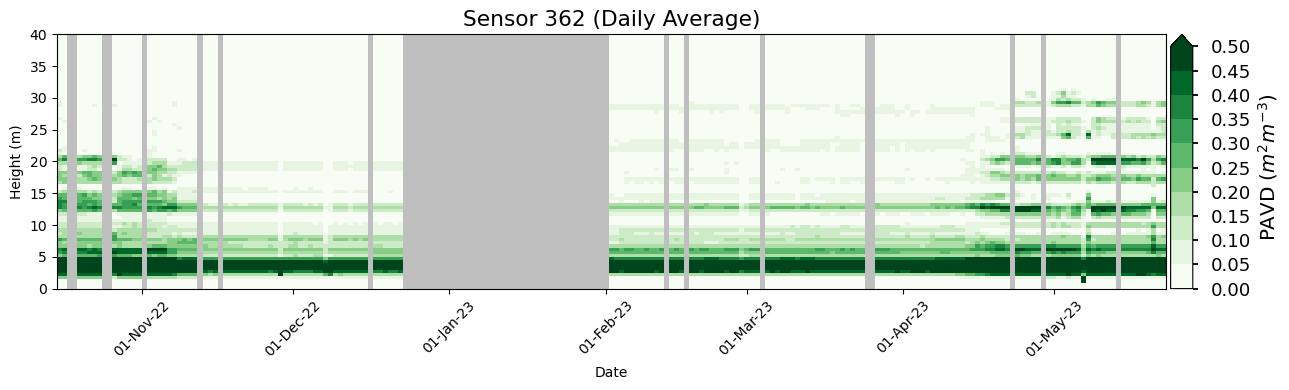

In [20]:
xextent = [leaf_dates[0],leaf_dates[-1]]
yextent = [0,max_h] 

pavd_grid = np.ma.masked_equal(pavd_grid, -9999)

visualize.plot_timseries_2d(pavd_grid[0,::-1,:], clim=[0,0.5], title=f'Sensor {sensor_id:d} (Daily Average)', nbins=10, 
                  cmap='Greens', label=r'PAVD ($m^{2} m^{-3}$)', xrotation=45, 
                  facecolor='0.75', extend='max', xextent=xextent, yextent=yextent, figsize=(13,4))

## Grid the weekly PAVD time-series

Aggregation may be preferred to smoothing for gap filling and reducing noise

In [21]:
nweeks = ndays // 7 + 1
with grid.LidarGrid(nweeks, nbins, 0, nbins, resolution=1, init_cntgrid=True) as grd:
    for i in range(nobs):
        d = leaf_hinge_vpp[i].datetime
        day = (d - leaf_hinge_vpp[0].datetime).days
        week = day // 7
        if d.hour in scan_hours:
            scan = scan_hours.index(d.hour)
            if quality_flags[scan][day]:
                if hasattr(leaf_hinge_vpp[i], 'pgap_theta_z'):
                    pai_z = leaf_hinge_vpp[i].calcHingePlantProfiles()
                    pavd = leaf_hinge_vpp[i].get_pavd(pai_z)
                    grd.add_column(pavd, week, method='MEAN')
        
    grd.finalize_grid(method='MEAN')
    pavd_grid = grd.get_grid()

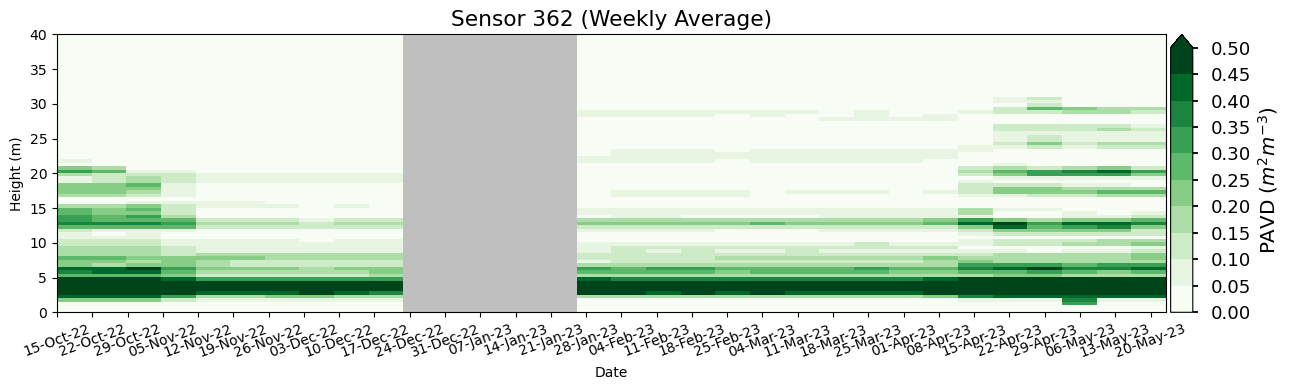

In [22]:
xextent = [leaf_dates[0],leaf_dates[-1]]
yextent = [0,max_h] 
xticks = [leaf_dates[0] + datetime.timedelta(days=7*x) for x in range(nweeks)]

pavd_grid = np.ma.masked_equal(pavd_grid, -9999)

visualize.plot_timseries_2d(pavd_grid[0,::-1,:], clim=[0,0.5], title=f'Sensor {sensor_id:d} (Weekly Average)', nbins=10, 
                  cmap='Greens', label=r'PAVD ($m^{2} m^{-3}$)', xrotation=20, 
                  facecolor='0.75', extend='max', xextent=xextent, yextent=yextent, figsize=(13,4), xticks=xticks)

## Temporal variation in interception of canopy elements

This is experimental but temporal variation is distinct for different canopy elements. Scans can be aligned through time if the tilt sensors readings are ignored, or one reading is applied to all scans.

### First grid all the scans to identify ones with artefacts.

In [23]:
leaf_hemi_files = sorted(hemi_hi_csv_list)
nobs = len(leaf_hemi_files)
resolution = 0.48

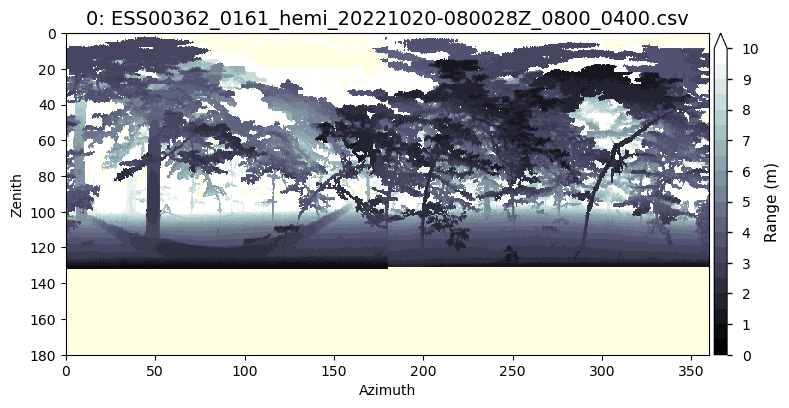

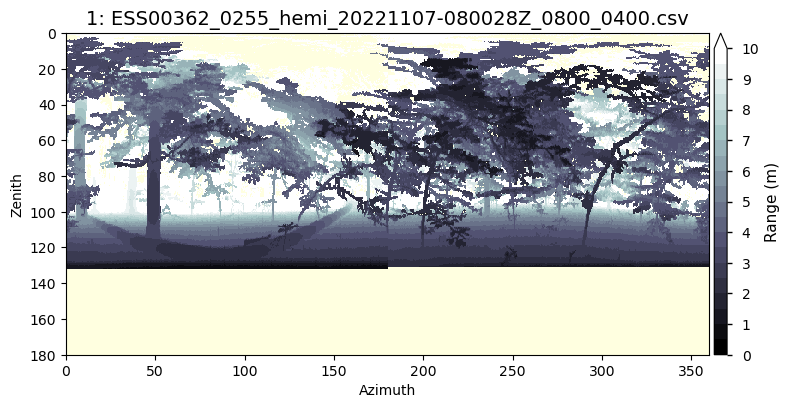

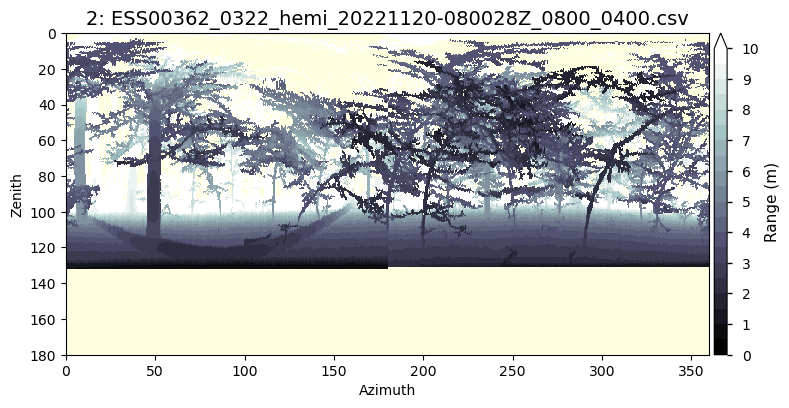

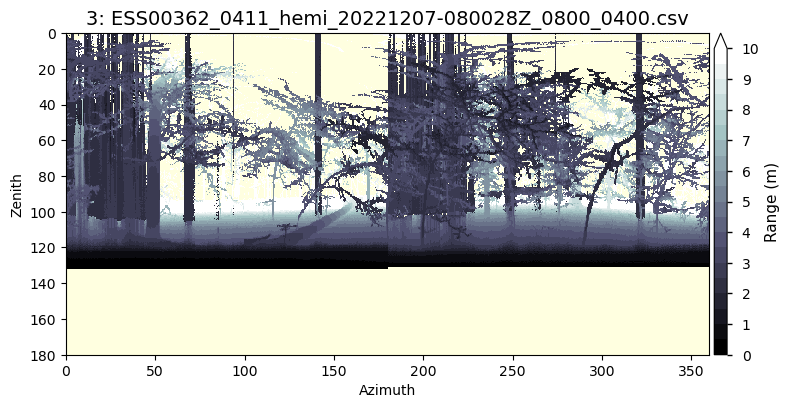

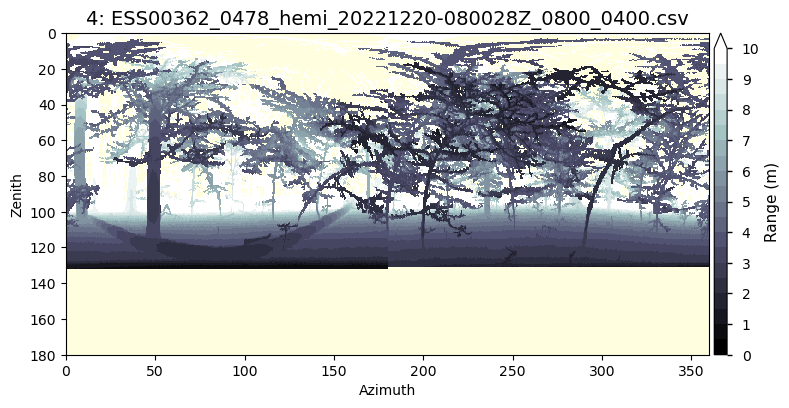

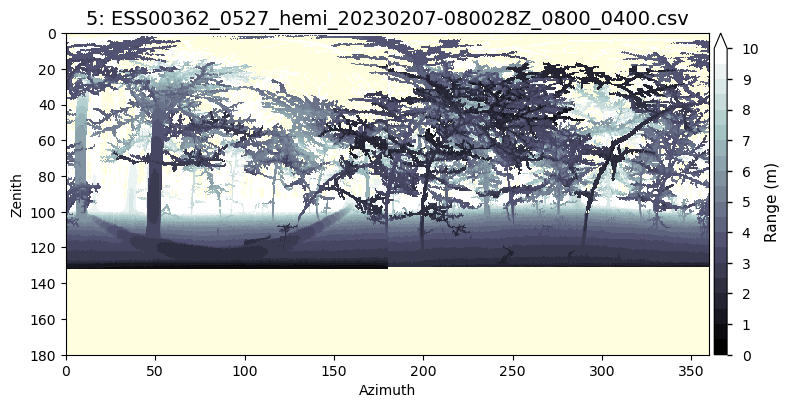

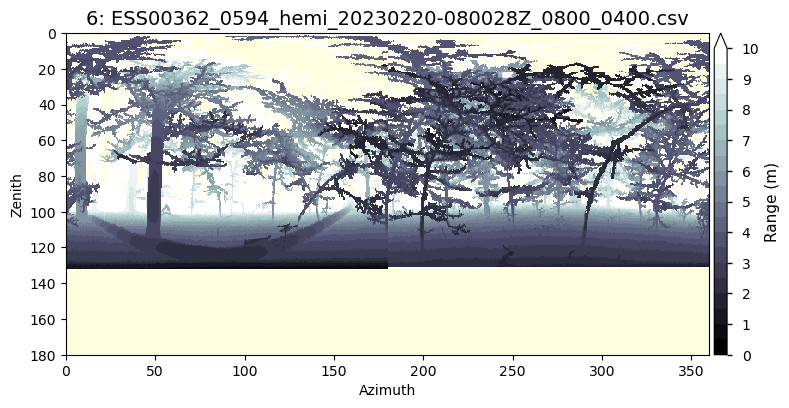

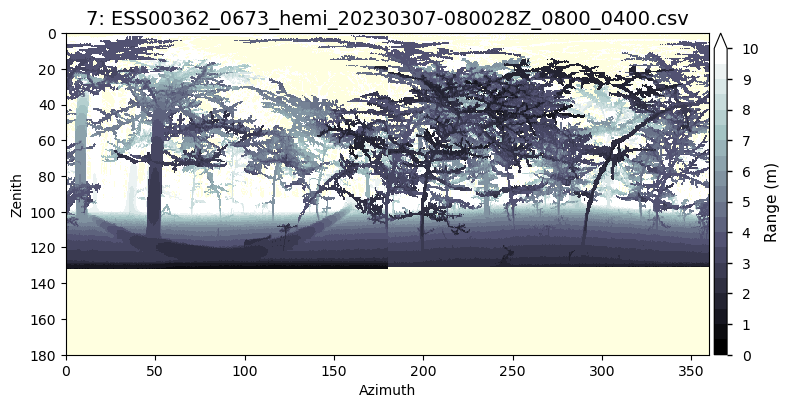

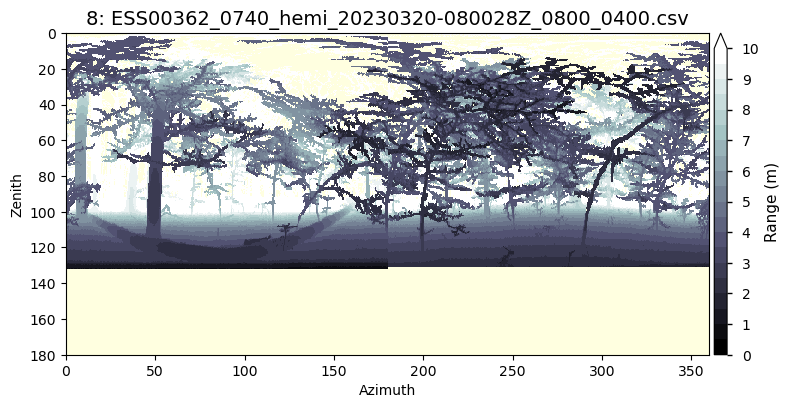

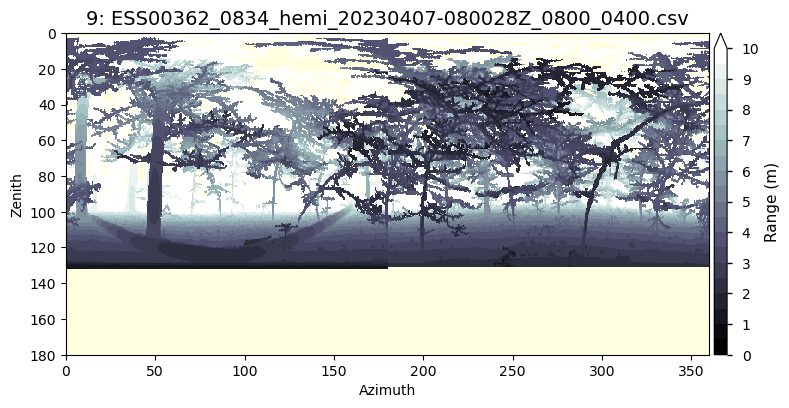

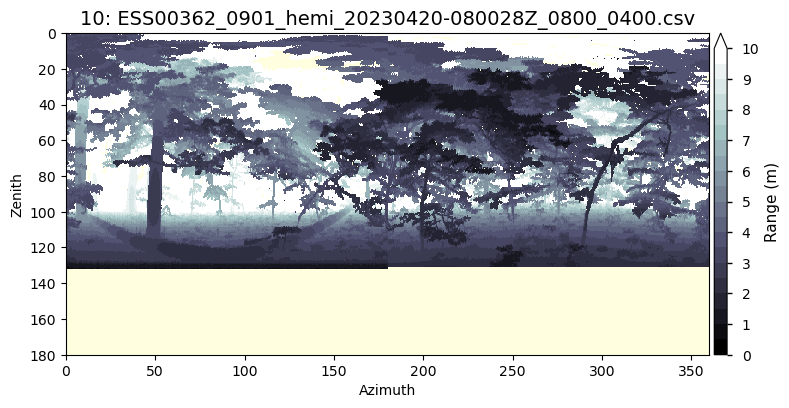

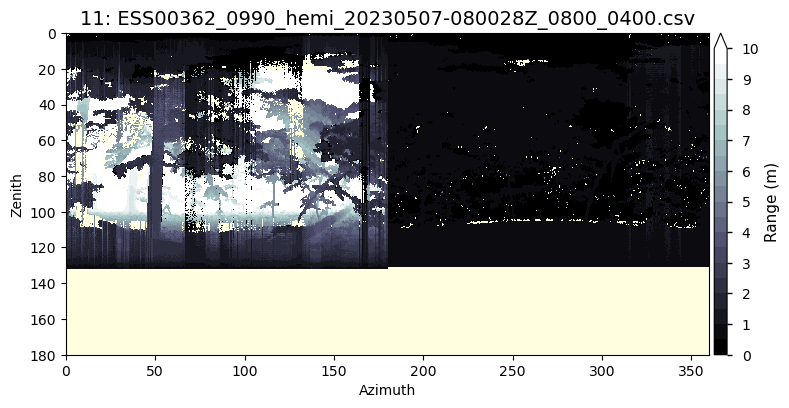

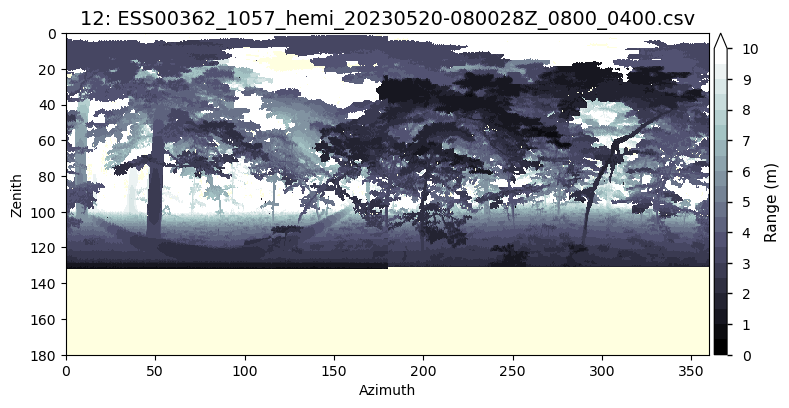

In [24]:
sh = nobs,int(180/resolution)+1,int(360/resolution)+1
leaf_hemi_stack = np.full(sh, -9999, dtype=float)
for i,hemi_file in enumerate(leaf_hemi_files):
    leaf_hemi_grid = grid.grid_leaf_spherical(hemi_file, resolution, attribute='range1',
        method='MIN', sensor_height=sensor_height, transform=False, zenith_offset=zenith_offset)
    leaf_hemi_stack[i] = leaf_hemi_grid
    visualize.plot_leaf_grid(leaf_hemi_grid, label='Range (m)', clim=[0,10], figsize=(8,6), 
        nbins=20, cmap='bone', extent=[0,360,180,0], title=f'{i:d}: {os.path.basename(hemi_file)}',
        xlabel='Azimuth', ylabel='Zenith', facecolor='lightyellow')

### Visualize change in interception over time

In [32]:
valid = [0,1,2,4,5,6,7,8,9,10,12] # hemi scans without visual artifacts
observed = ~np.isnan(leaf_hemi_stack[valid]) & (leaf_hemi_stack[valid] != -9999)
sh = 1,int(180/resolution)+1,int(360/resolution)+1
leaf_std_grid = np.full(sh, -9999, dtype=float)
_ = np.std(leaf_hemi_stack[valid], out=leaf_std_grid, axis=0, keepdims=True, 
           where=np.sum(observed, axis=0, keepdims=True) > 2)

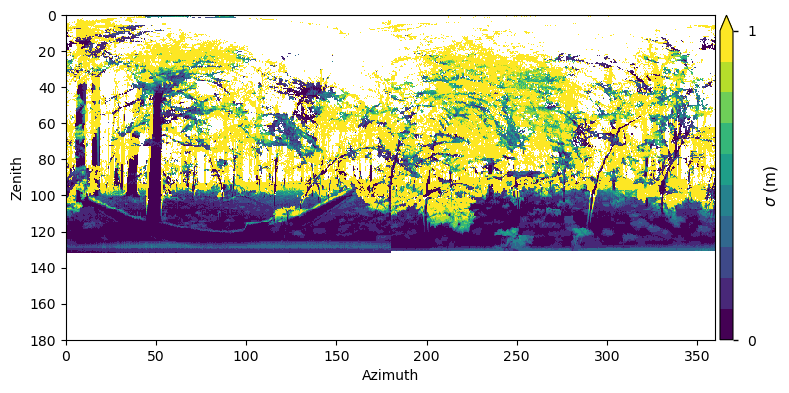

In [26]:
visualize.plot_leaf_grid(leaf_std_grid, label=r'$\sigma$ (m)', clim=[0,1], figsize=(8,6), 
               cmap='viridis', extent=[0,360,180,0],
               xlabel='Azimuth', ylabel='Zenith', facecolor='white')

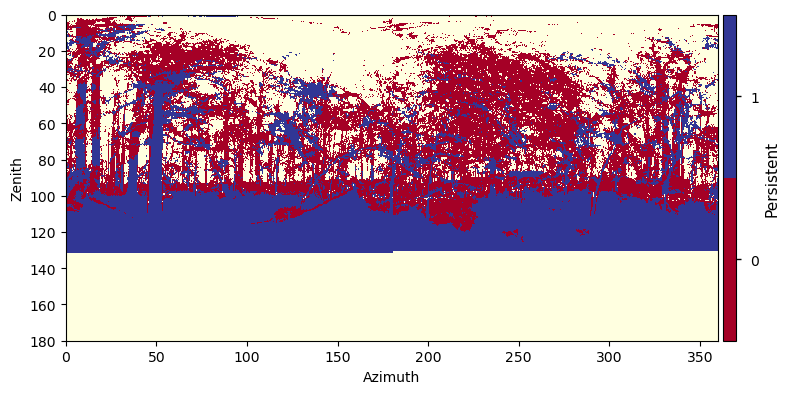

In [27]:
leaf_label_grid = np.where(leaf_std_grid > 0.5, 0, 1)
leaf_label_grid = np.where(np.isnan(leaf_std_grid), -9999, leaf_label_grid)
visualize.plot_leaf_grid(leaf_label_grid, label='Persistent', clim=[-0.5,1.5], figsize=(8,6), 
               nbins=2, cmap='RdYlBu', extent=[0,360,180,0], xlabel='Azimuth', 
               ylabel='Zenith', facecolor='lightyellow', extend='neither')

In [28]:
range_tol = 0.5
sh = int(180/resolution)+1,int(360/resolution)+1
leaf_hemi_change = np.full(sh, -9999, dtype=int)
for i,v in enumerate(valid):
    nonull = leaf_hemi_stack[v] != -9999
    if i > 0:        
        idx = nonull & (leaf_hemi_stack[v] > leaf_hemi_tmp+range_tol)
        leaf_hemi_change[idx] -= 1
        leaf_hemi_tmp[idx] = leaf_hemi_stack[v][idx]
        
        idx = nonull & (leaf_hemi_stack[v] < leaf_hemi_tmp-range_tol)
        leaf_hemi_change[idx] += 1
        leaf_hemi_tmp[idx] = leaf_hemi_stack[v][idx]
        
        idx = nonull & (leaf_hemi_tmp == -9999)
        leaf_hemi_change[idx] += 1
        leaf_hemi_tmp[idx] = leaf_hemi_stack[v][idx]
    else:
        leaf_hemi_tmp = leaf_hemi_stack[i]

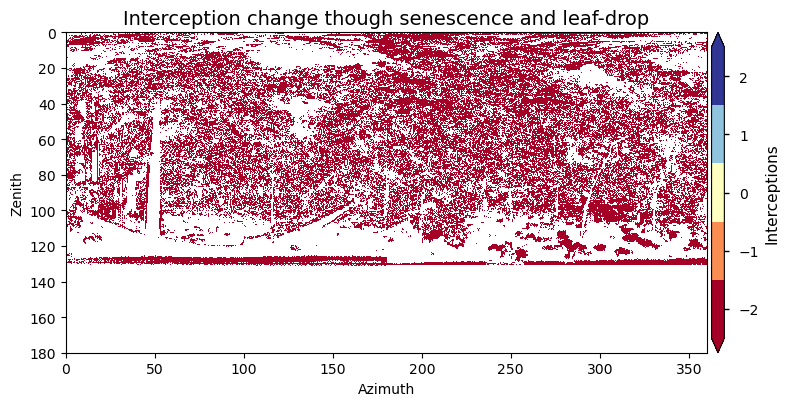

In [29]:
leaf_hemi_change = np.expand_dims(leaf_hemi_change, 0)
visualize.plot_leaf_grid(leaf_hemi_change, label='Interceptions', clim=[-2.5,2.5], figsize=(8,6), 
               nbins=5, cmap='RdYlBu', extent=[0,360,180,0], xlabel='Azimuth', 
               ylabel='Zenith', facecolor='white', extend='both',
               title='Interception change though senescence and leaf-drop')